In [432]:
import os, sys, glob, re
import datetime as dt
import numpy as np
from calendar import monthrange
from matplotlib.dates import date2num, num2date
# import h5py
from sklearn import decomposition
import nimfa
from scipy import signal

sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')
from mi.instrument.kut.ek60.ooicore.zplsc_b import *
# from concat_raw import get_num_days_pings, get_data_from_h5
# from echogram_decomp import find_nearest_time_idx,reshape_into_3freq,reshape_into_1freq,\
#     sep_into_freq,plot_decomp_v,plot_decomp_transform
from db_diff import *

import matplotlib.pyplot as plt
# from modest_image import imshow
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [433]:
%matplotlib inline

In [434]:
date_start = dt.date(2015,8,17)
date_end = dt.date(2015,10,17)
date_wanted = [(date_start+dt.timedelta(days=xx)).strftime('%Y%m%d') for xx in range((date_end-date_start).days + 1)]

In [435]:
data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
save_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_new/'
save_fname = '%s-%s' % (date_start.strftime('%Y%m%d'),date_end.strftime('%Y%m%d'))

In [546]:
# Set param
hour_all = range(24)
min_all = range(20)
sec_all = range(0,60,5)
ping_per_day = len(hour_all)*len(min_all)*len(sec_all)

ping_bin_range = 40
depth_bin_range = 10
tvg_correction_factor = 2

ping_per_day_mvbs = ping_per_day/ping_bin_range

*****************************************
## The section below is for testing stuff...

In [389]:
dd= date_wanted[60]
# load files and get calibration params
fname = glob.glob(os.path.join(data_path,'OOI-D%s*.raw' %dd))[0]
particle_data, data_times, power_data, freq, bin_size, config_header, config_transducer = \
    parse_echogram_file(fname)
cal_params = get_cal_params(power_data,particle_data,config_header,config_transducer)

# swap sequence of 120 kHz and 38 kHz cal_params and data
cal_params = [cal_params[fn] for fn in [1,0,2]]
power_data = get_power_data_mtx(power_data,freq)

# clean data
Sv_raw_tmp = np.ma.empty((power_data.shape))
Sv_corr_tmp = np.ma.empty((power_data.shape))
Sv_noise_tmp = np.ma.empty((power_data.shape[0:2]))
for fn in range(power_data.shape[0]):
    noise_est,ping_bin_num = get_noise(power_data[fn,:,:],bin_size,ping_bin_range,depth_bin_range)
    Sv_raw_tmp[fn,:,:],Sv_corr_tmp[fn,:,:],Sv_noise_tmp[fn,:] = \
            remove_noise(power_data[fn,:,:],cal_params[fn],noise_est.min(),ping_bin_range,tvg_correction_factor)

# set up indexing to get wanted pings
dd = dt.datetime.strptime(dd,'%Y%m%d')
time_wanted = [dt.datetime(dd.year,dd.month,dd.day,hh,mm,ss) for hh in hour_all for mm in min_all for ss in sec_all]
idx_wanted = [find_nearest_time_idx(data_times,tt,2) for tt in time_wanted]
notnanidx = np.argwhere(~np.isnan(idx_wanted)).flatten()
notnanidx_in_all = np.array(idx_wanted)[notnanidx].astype(int)

# get data to to saved
Sv_raw = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
Sv_corr = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
Sv_noise = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],1))

Sv_raw[:,:,notnanidx] = Sv_raw_tmp[:,:,notnanidx_in_all]
Sv_corr[:,:,notnanidx] = Sv_corr_tmp[:,:,notnanidx_in_all]
Sv_noise[:,:,0] = Sv_noise_tmp
ping_time = date2num(time_wanted)

idx_save_mask = np.argwhere(np.isnan(idx_wanted))
Sv_raw[:,:,idx_save_mask] = np.ma.masked
Sv_raw[:,:,idx_save_mask].mask = True
Sv_corr[:,:,idx_save_mask] = np.ma.masked
Sv_corr[:,:,idx_save_mask].mask = True

MVBS = get_MVBS(Sv_corr,bin_size,ping_bin_range,depth_bin_range=5)

2017-10-18 07:43:20,935 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20151016-T000000.raw'


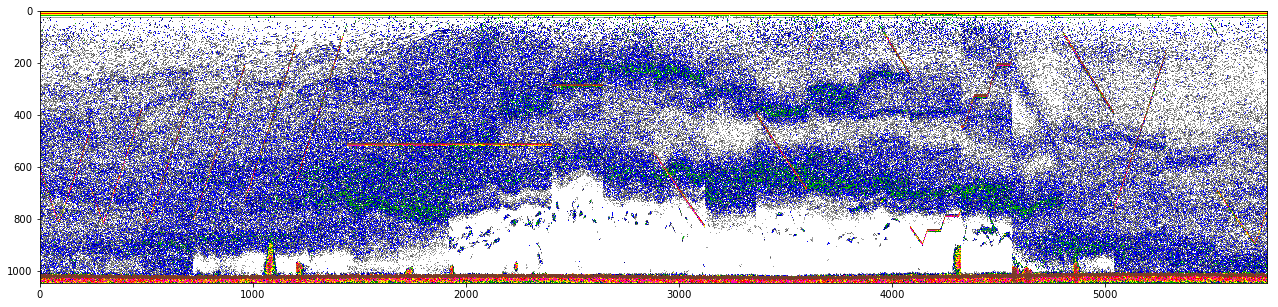

In [391]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

In [392]:
idx_bkg = np.nonzero(Sv_corr<-40)

In [411]:
Sv_bkg = np.ma.copy(Sv_corr)

In [416]:
Sv_bkg[idx_bkg] = np.nan
Sv_bkg[idx_bkg].mask= True

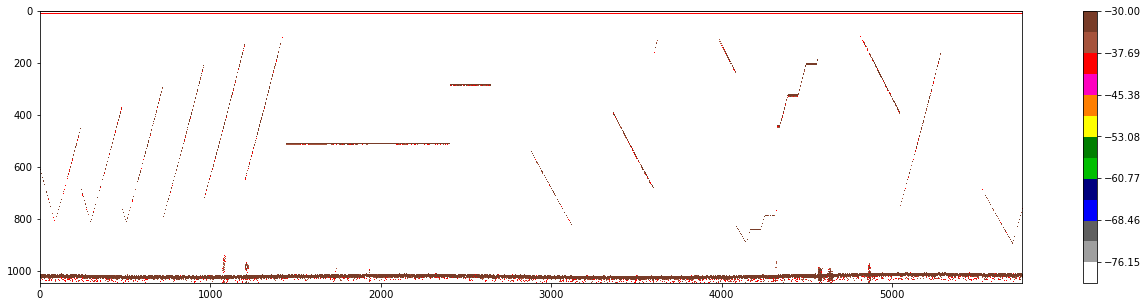

In [417]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_bkg[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
plt.colorbar()

In [421]:
import cv2

In [430]:
Sv_bkg_blur = cv2.filter2D(Sv_bkg[0,:,:],-1,np.ones((3,3),np.float32)/25)

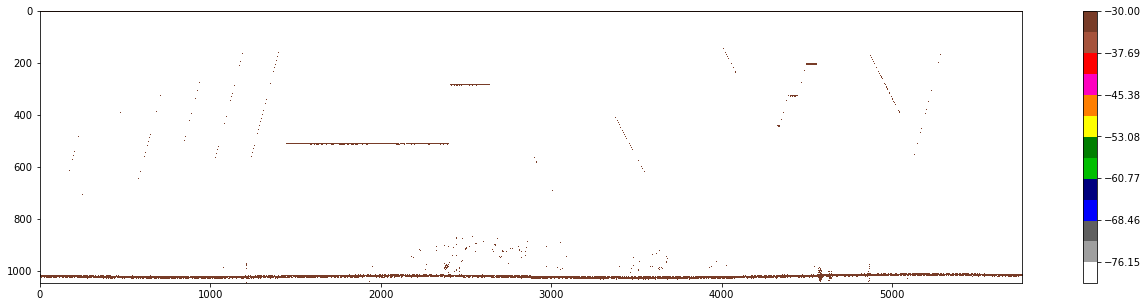

In [431]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_bkg_blur,aspect='auto',cmap=e_cmap,norm=e_norm)
plt.colorbar()

In [352]:
idx_large = np.nonzero(Sv_corr>-45)

In [357]:
Sv_corr[idx_large] = np.ma.masked

In [384]:
idx_large

(array([0, 0, 0, ..., 2, 2, 2]),
 array([   0,    0,    0, ..., 1045, 1045, 1045]),
 array([   0,    1,    2, ..., 5502, 5508, 5512]))

In [369]:
idx_large_array=np.array(idx_large)

In [371]:
idx_large_array

array([[   0,    0,    0, ...,    2,    2,    2],
       [   0,    0,    0, ..., 1045, 1045, 1045],
       [   0,    1,    2, ..., 5502, 5508, 5512]])

In [388]:
type(Sv_corr)

numpy.ma.core.MaskedArray

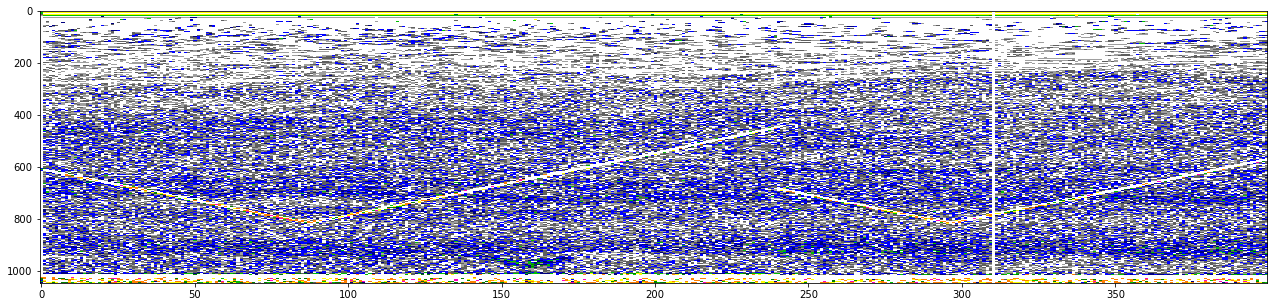

In [358]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,0:400],aspect='auto',cmap=e_cmap,norm=e_norm)

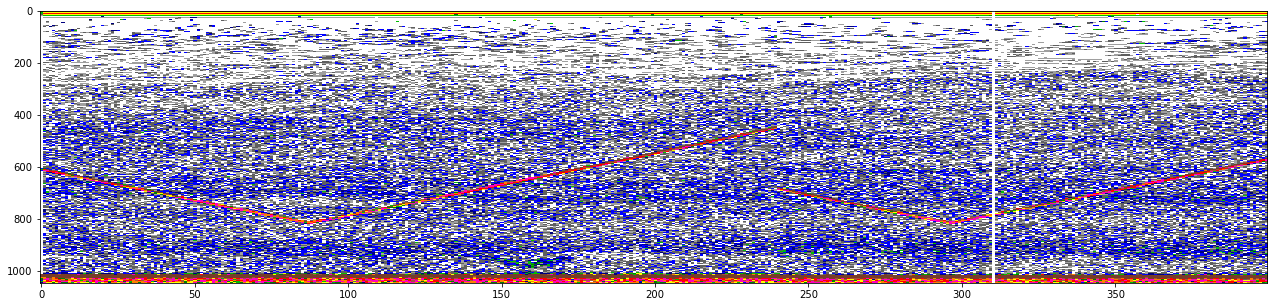

In [327]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,0:400],aspect='auto',cmap=e_cmap,norm=e_norm)

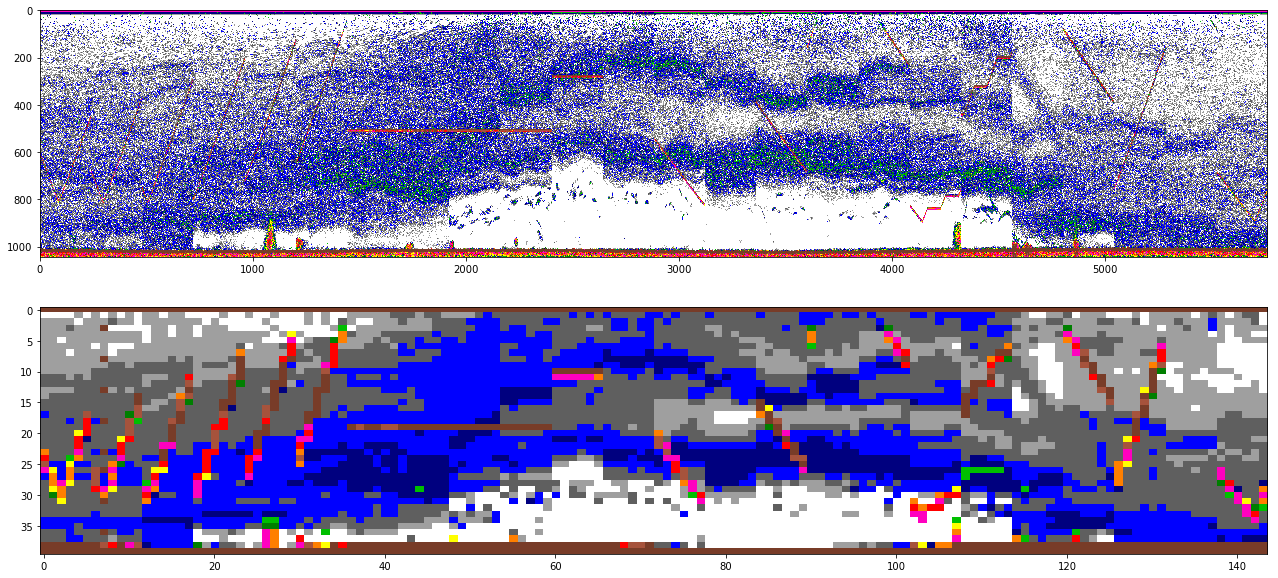

In [306]:
fig,ax = plt.subplots(2,1,figsize=(22,10))
ax[0].imshow(Sv_corr[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
ax[1].imshow(MVBS[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

In [363]:
Sv_corr_med0 = signal.medfilt2d(Sv_corr[0,:,:],kernel_size=9)

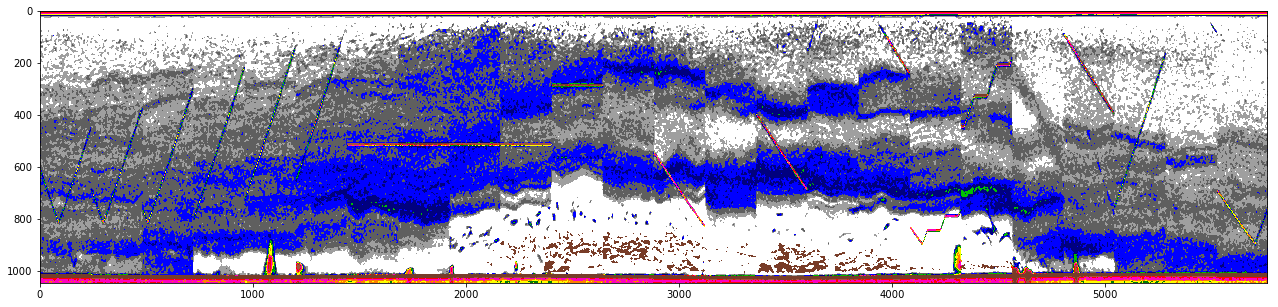

In [364]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr_med0,aspect='auto',cmap=e_cmap,norm=e_norm)

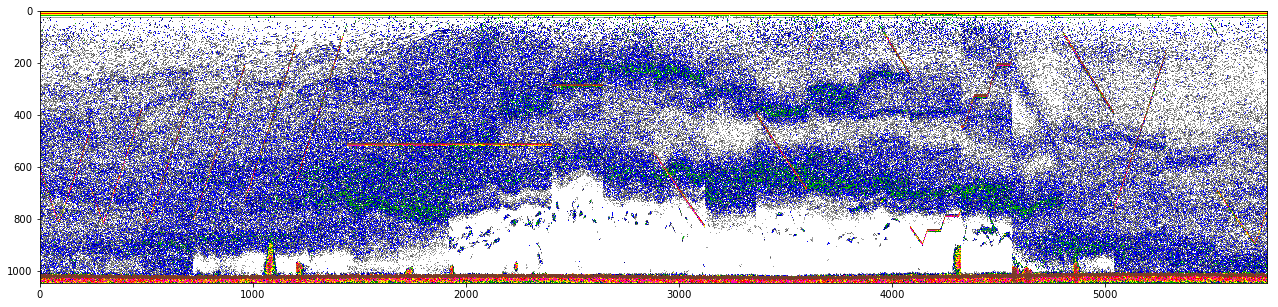

In [299]:
plt.subplots(figsize=(22,5))
plt.imshow(Sv_corr[0,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

## End of testing stuff...
************************************************************

## Unpack .Raw files into HDF5

In [437]:
for iD,dd in zip(range(len(date_wanted)),date_wanted):

    # load files and get calibration params
    fname = glob.glob(os.path.join(data_path,'OOI-D%s*.raw' %dd))[0]
    particle_data, data_times, power_data, freq, bin_size, config_header, config_transducer = \
        parse_echogram_file(fname)
    cal_params = get_cal_params(power_data,particle_data,config_header,config_transducer)

    # swap sequence of 120 kHz and 38 kHz cal_params and data
    cal_params = [cal_params[fn] for fn in [1,0,2]]
    power_data = get_power_data_mtx(power_data,freq)

    # clean data
    Sv_raw_tmp = np.ma.empty((power_data.shape))
    Sv_corr_tmp = np.ma.empty((power_data.shape))
    Sv_noise_tmp = np.ma.empty((power_data.shape[0:2]))
    for fn in range(power_data.shape[0]):
        noise_est,ping_bin_num = get_noise(power_data[fn,:,:],bin_size,ping_bin_range,depth_bin_range)
        Sv_raw_tmp[fn,:,:],Sv_corr_tmp[fn,:,:],Sv_noise_tmp[fn,:] = \
                remove_noise(power_data[fn,:,:],cal_params[fn],noise_est.min(),ping_bin_range,tvg_correction_factor)

    # set up indexing to get wanted pings
    dd = dt.datetime.strptime(dd,'%Y%m%d')
    time_wanted = [dt.datetime(dd.year,dd.month,dd.day,hh,mm,ss) for hh in hour_all for mm in min_all for ss in sec_all]
    idx_wanted = [find_nearest_time_idx(data_times,tt,2) for tt in time_wanted]
    notnanidx = np.argwhere(~np.isnan(idx_wanted)).flatten()
    notnanidx_in_all = np.array(idx_wanted)[notnanidx].astype(int)

    # get data to to saved
    Sv_raw = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
    Sv_corr = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],ping_per_day))
    Sv_noise = np.ma.empty((Sv_raw.shape[0],Sv_raw.shape[1],1))
    
    Sv_raw[:,:,notnanidx] = Sv_raw_tmp[:,:,notnanidx_in_all]
    Sv_corr[:,:,notnanidx] = Sv_corr_tmp[:,:,notnanidx_in_all]
    Sv_noise[:,:,0] = Sv_noise_tmp
    ping_time = date2num(time_wanted)

    idx_save_mask = np.argwhere(np.isnan(idx_wanted))
    Sv_raw[:,:,idx_save_mask] = np.ma.masked
    Sv_corr[:,:,idx_save_mask] = np.ma.masked
    
    # save into h5 file
    sz = Sv_raw.shape
    f = h5py.File(os.path.join(save_path,'%s_Sv.h5' %save_fname),"a")
    if "Sv_raw" in f:  # if file alread exist and contains Sv mtx
        print '-- H5 file exists, append new data mtx...'
        # append new data
        sz_exist = f['Sv_raw'].shape  # shape of existing Sv mtx
        f['Sv_raw'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+sz[2]))
        f['Sv_raw'][:,:,sz_exist[2]:] = Sv_raw
        f['Sv_corr'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+sz[2]))
        f['Sv_corr'][:,:,sz_exist[2]:] = Sv_corr
        f['Sv_noise'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+1))
        f['Sv_noise'][:,:,sz_exist[2]:] = Sv_noise
        f['ping_time'].resize((sz_exist[2]+sz[2],))
        f['ping_time'][sz_exist[2]:] = ping_time
    else:
        print '-- New H5 file, create new dataset...'
        # create dataset and save
        f.create_dataset("Sv_raw", sz, maxshape=(sz[0],sz[1],None), data=Sv_raw, chunks=True)
        f.create_dataset("Sv_corr", sz, maxshape=(sz[0],sz[1],None), data=Sv_corr, chunks=True)
        f.create_dataset("Sv_noise", (Sv_raw.shape[0],Sv_raw.shape[1],1), maxshape=(sz[0],sz[1],None), data=Sv_noise, chunks=True)
        f.create_dataset("ping_time", (sz[2],), maxshape=(None,), data=ping_time, chunks=True)
        f.create_dataset("depth_bin_size",data=bin_size)
    f.close()

    # get MVBS
    MVBS = get_MVBS(Sv_corr,bin_size,ping_bin_range,depth_bin_range=5)
    
    # save into h5 file
    sz = MVBS.shape
    ping_time_MVBS = ping_time[0::ping_bin_range]  # get ping time every ping_bin_range for MVBS
    
    f = h5py.File(os.path.join(save_path,'%s_MVBS.h5' %save_fname),"a")
    if "MVBS" in f:  # if file alread exist and contains Sv mtx
        print '-- H5 file exists, append new data mtx...'
        # append new data
        sz_exist = f['MVBS'].shape  # shape of existing Sv mtx
        f['MVBS'].resize((sz_exist[0],sz_exist[1],sz_exist[2]+sz[2]))
        f['MVBS'][:,:,sz_exist[2]:] = MVBS
        f['ping_time'].resize((sz_exist[2]+sz[2],))
        f['ping_time'][sz_exist[2]:] = ping_time_MVBS
    else:
        print '-- New H5 file, create new dataset...'
        # create dataset and save
        f.create_dataset("MVBS", sz, maxshape=(sz[0],sz[1],None), data=MVBS, chunks=True)
        f.create_dataset("ping_time", (sz[2],), maxshape=(None,), data=ping_time_MVBS, chunks=True)
        f.create_dataset("depth_bin_size",data=depth_bin_range)
    f.close()

2017-10-24 17:34:14,928 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150817-T000000.raw'
-- New H5 file, create new dataset...
-- New H5 file, create new dataset...
2017-10-24 17:34:49,735 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150818-T000000.raw'
-- H5 file exists, append new data mtx...
-- H5 file exists, append new data mtx...
2017-10-24 17:35:23,713 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150819-T000000.raw'
-- H5 file exists, append new data mtx...
-- H5 file exists, append new data mtx...
2017-10-24 17:35:57,211 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150820-T000000.raw'
-- H5 file exists, append new data mtx...
-- H5 file exists,

## Load MVBS data and process

In [438]:
f = h5py.File(os.path.join(save_path,'%s_MVBS.h5' %save_fname),"r")

In [439]:
MVBS = np.array(f['MVBS'])

The echogram doesn't look so nice when plotting all 62 days together.

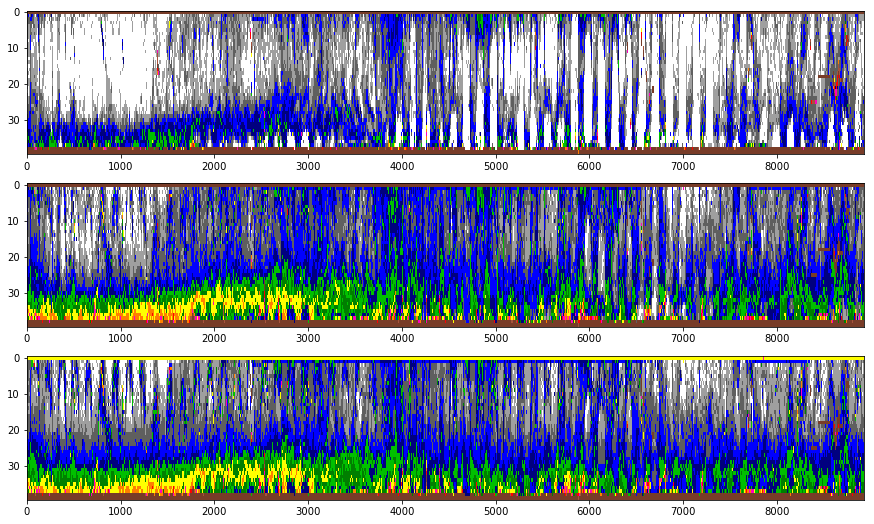

In [440]:
fig,ax = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(MVBS[0,:,0:],aspect='auto',cmap=e_cmap,norm=e_norm)
ax[1].imshow(MVBS[1,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)
ax[2].imshow(MVBS[2,:,:],aspect='auto',cmap=e_cmap,norm=e_norm)

But the echogram structures are easier to see if only plotting out a shorter section. Below we plot the last 5 days, in which there are lots of returns from the profiler. Including these returns or not makes a difference in how the NMF decompose the data matrix.

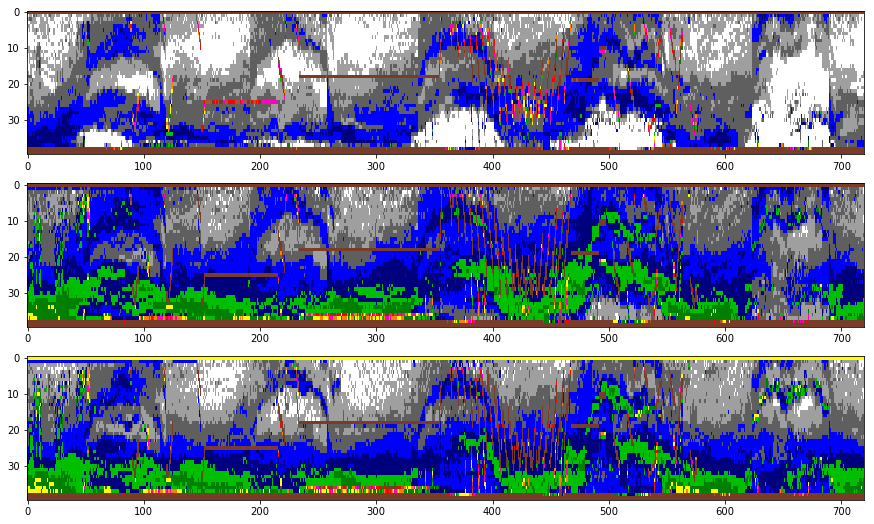

In [547]:
plot_start_day = 57
plot_range_day = 5
fig,ax = plt.subplots(3,1,figsize=(15,9))
ax[0].imshow(MVBS[0,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=e_cmap,norm=e_norm)
ax[1].imshow(MVBS[1,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=e_cmap,norm=e_norm)
ax[2].imshow(MVBS[2,:,ping_per_day_mvbs*plot_start_day+np.arange(ping_per_day_mvbs*plot_range_day)].T,aspect='auto',cmap=e_cmap,norm=e_norm)

## NMF in the linear domain

The decomposition seems to be dominated by echoes from the profiler when running NMF in the linear domain. I tested how the decomposition would change depending on if or not the last 3 days of data are included in the data for decomposition.

### *Not* include data from the last 3 days

In all decomposition below I took out the first and last 2 depth bins. The first depth bin is blank-out region of the transducer. The last 2 depth bins are returns from the sea surface. They seem to throw off NMF and result into one strong component that contains data from these depth bins.

In the first test I did not include data from the last 3 days in the decomposition (the profiler echoes are very strong in day -2).

In [559]:
mvbs = 10**(MVBS[:,1:-2,:-3*ping_per_day_mvbs]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [560]:
n_comp = 5
nmf_min = decomposition.NMF(n_components=n_comp)
W_nmf = nmf_min.fit_transform(mvbs_long)
H_nmf = nmf_min.components_
V_nmf = H_nmf.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

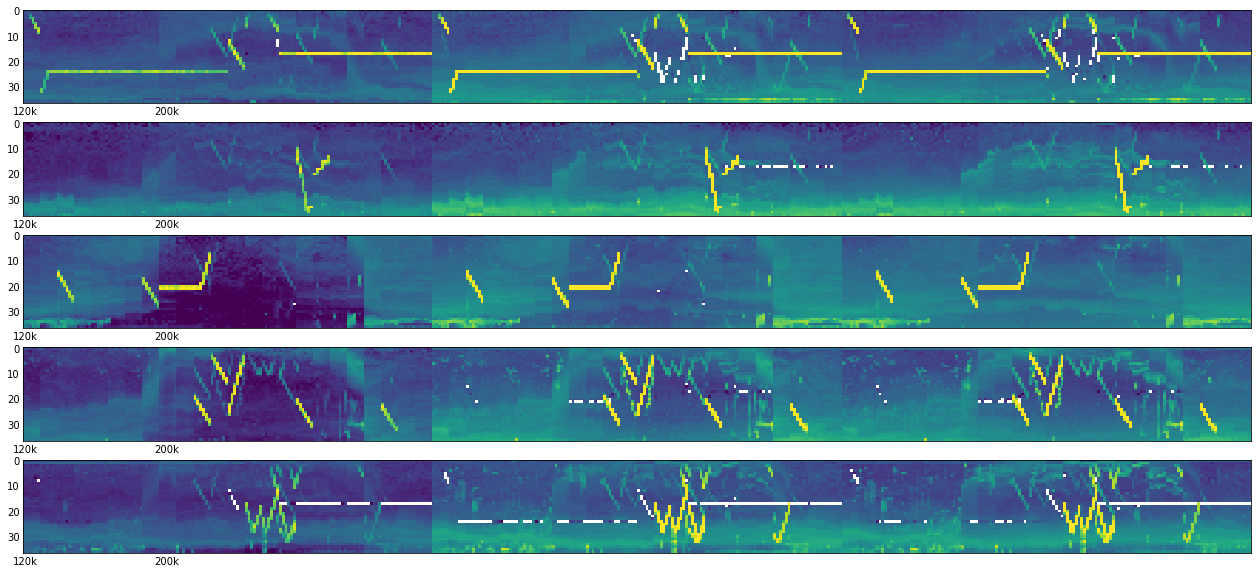

In [561]:
fig,ax=plt.subplots(n_comp,1,sharey=True,figsize=(22,10))
for c in range(n_comp):
    vlog = 10*np.ma.log10(V_nmf[c,:,:])
    cmean = np.mean(vlog)
    cstd = np.std(vlog)
    cmin = max((np.min(vlog),cmean-2*cstd))
    cmax = min((np.max(vlog),cmean+4*cstd))
    ax[c].imshow(vlog,aspect='auto',vmin=cmin,vmax=cmax)
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)

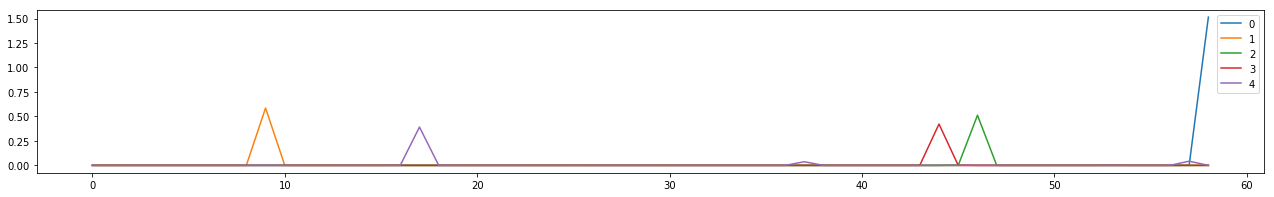

In [562]:
plt.figure(figsize=(22,3))
labels = [str(x) for x in range(n_comp)]
for w, label in zip(W_nmf.T, labels):
    plt.plot(w, label=label)
plt.legend()

### Include data from all days

If we include data from the last 3 days in the decomposition the results are quite a bit messier in terms of having the profiler echoes dominating the components.

In [540]:
mvbs = 10**(MVBS[:,1:-2,:]/10)
mvbs_3freq = np.array([mvbs[ff,:,:].T.reshape((-1,ping_per_day_mvbs*mvbs.shape[1])) for ff in range(3)])
mvbs_long = mvbs_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*mvbs.shape[1]*3))

In [541]:
n_comp = 5
nmf_min = decomposition.NMF(n_components=n_comp)
W_nmf = nmf_min.fit_transform(mvbs_long)
H_nmf = nmf_min.components_
V_nmf = H_nmf.reshape((n_comp,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

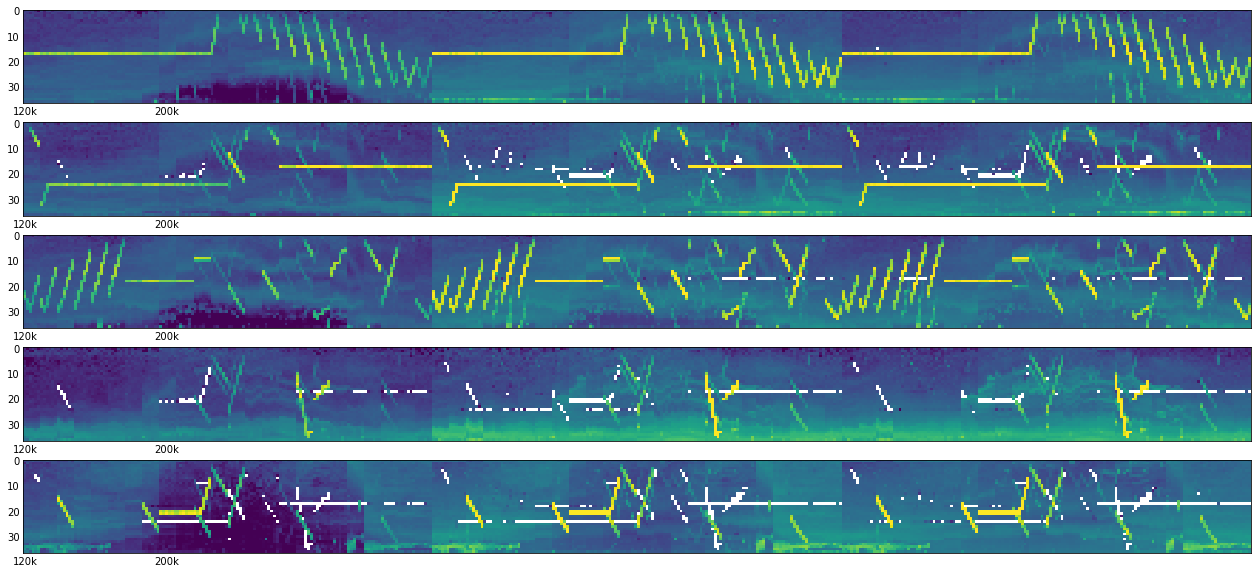

In [542]:
fig,ax=plt.subplots(n_comp,1,sharey=True,figsize=(22,10))
for c in range(n_comp):
    vlog = 10*np.ma.log10(V_nmf[c,:,:])
    cmean = np.mean(vlog)
    cstd = np.std(vlog)
    cmin = max((np.min(vlog),cmean-2*cstd))
    cmax = min((np.max(vlog),cmean+4*cstd))
    ax[c].imshow(vlog,aspect='auto',vmin=cmin,vmax=cmax)
    ax[c].set_xticklabels(['38k','120k','200k'])
    ax[c].tick_params('both', length=0)

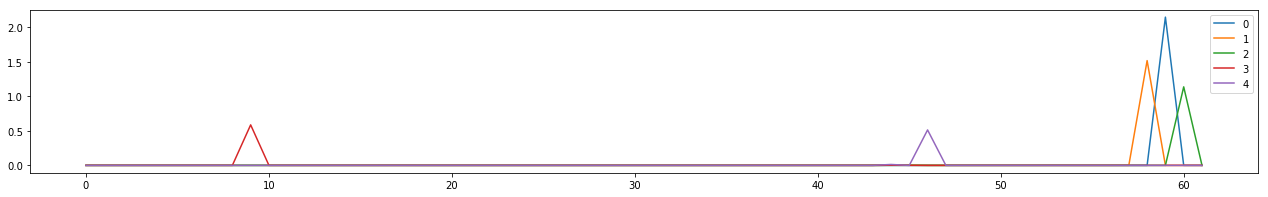

In [543]:
plt.figure(figsize=(22,3))
labels = [str(x) for x in range(n_comp)]
for w, label in zip(W_nmf.T, labels):
    plt.plot(w, label=label)
plt.legend()

## NMF in the log domain

The decomposition seems to be more dominated by echoes from biological sources when running NMF in the log domain. This seems to be because the differences between the very high energy (profiler) and low energy (biological sources) parts are much smaller in the log-transformed data?

I again tested how the decomposition would change depending on if or not the last 3 days of data are included in the data for decomposition.

### *Not* include data from the last 3 days

In [563]:
MVBS_copy = np.copy(MVBS[:,1:-2,:-3*ping_per_day_mvbs])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

In [564]:
n_comp = 5
M_nmf_min = decomposition.NMF(n_components=n_comp)
M_W_nmf = M_nmf_min.fit_transform(MVBS_long-MVBS_long.min())
M_H_nmf = M_nmf_min.components_
M_V_nmf = M_H_nmf.reshape((5,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

In [565]:
fig,ax=plt.subplots(5,1,sharey=True,figsize=(22,10))
for c in range(n_comp):
    ax[c].imshow(M_V_nmf[c,:,:],aspect='auto',cmap=)

SyntaxError: invalid syntax (<ipython-input-565-71976f70235c>, line 3)

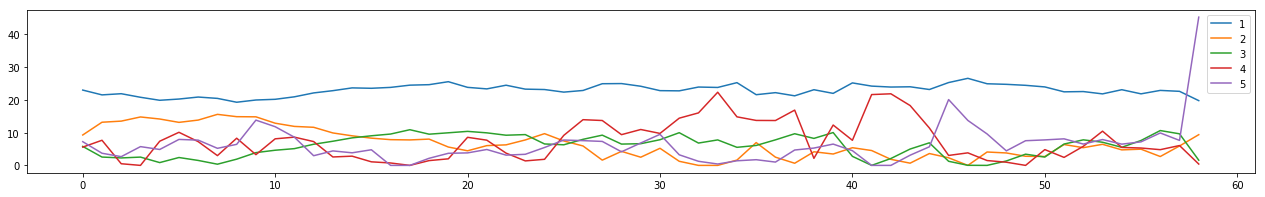

In [566]:
plt.figure(figsize=(22,3))
labels =['1', '2', '3','4','5']
for w, label in zip(M_W_nmf.T, labels):
    plt.plot(w, label=label)
plt.legend()

### Include data from all days

In [567]:
MVBS_copy = np.copy(MVBS[:,1:-2,:])
MVBS_3freq = np.array([MVBS_copy[ff,:,:].T.reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1])) for ff in range(3)])
MVBS_long = MVBS_3freq.swapaxes(0,1).reshape((-1,ping_per_day_mvbs*MVBS_copy.shape[1]*3))

In [568]:
n_comp = 5
M_nmf_min = decomposition.NMF(n_components=n_comp)
M_W_nmf = M_nmf_min.fit_transform(MVBS_long-MVBS_long.min())
M_H_nmf = M_nmf_min.components_
M_V_nmf = M_H_nmf.reshape((5,3*ping_per_day_mvbs,-1)).swapaxes(1,2)

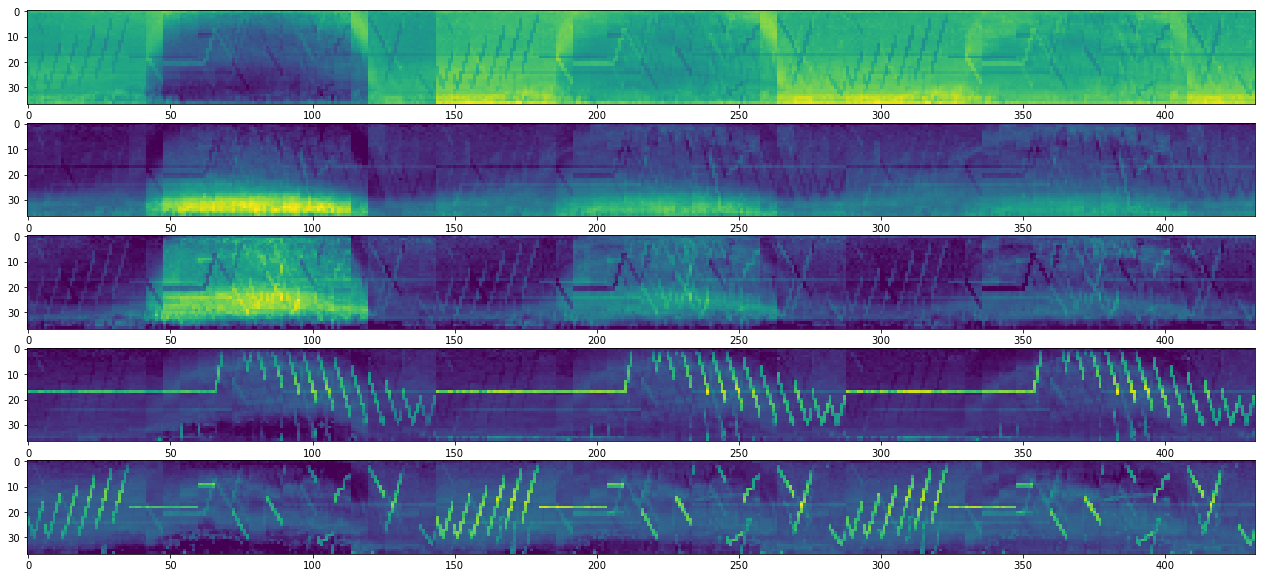

In [569]:
fig,ax=plt.subplots(5,1,sharey=True,figsize=(22,10))
for c in range(n_comp):
    ax[c].imshow(M_V_nmf[c,:,:],aspect='auto')

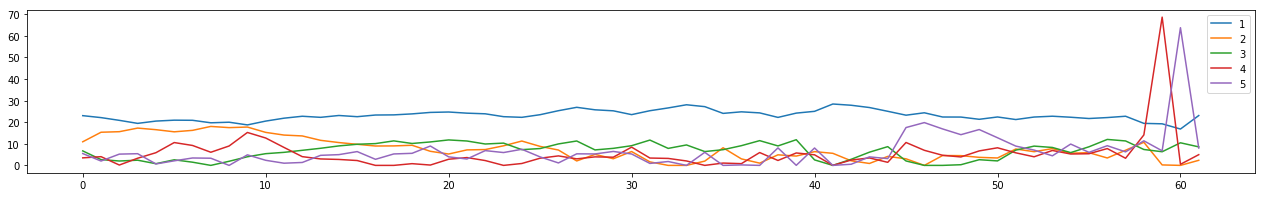

In [570]:
plt.figure(figsize=(22,3))
labels =['1', '2', '3','4','5']
for w, label in zip(M_W_nmf.T, labels):
    plt.plot(w, label=label)
plt.legend()

## Freq-differencing

In [96]:
Sv_1 = MVBS[2,:,:]
Sv_2 = MVBS[0,:,:]

yes_1 = ~np.isnan(Sv_1)
yes_2 = ~np.isnan(Sv_2)
Sv_diff_12 = Sv_1 - Sv_2
Sv_diff_12[yes_1 & ~yes_2] = np.inf
Sv_diff_12[~yes_1 & yes_2] = -np.inf

idx_fish = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2)) & (Sv_diff_12>-16)
idx_fish_2 = (np.isneginf(Sv_diff_12) | (Sv_diff_12<-2))
idx_zoop = np.isposinf(Sv_diff_12) | (Sv_diff_12>-2)
idx_other = Sv_diff_12<-16

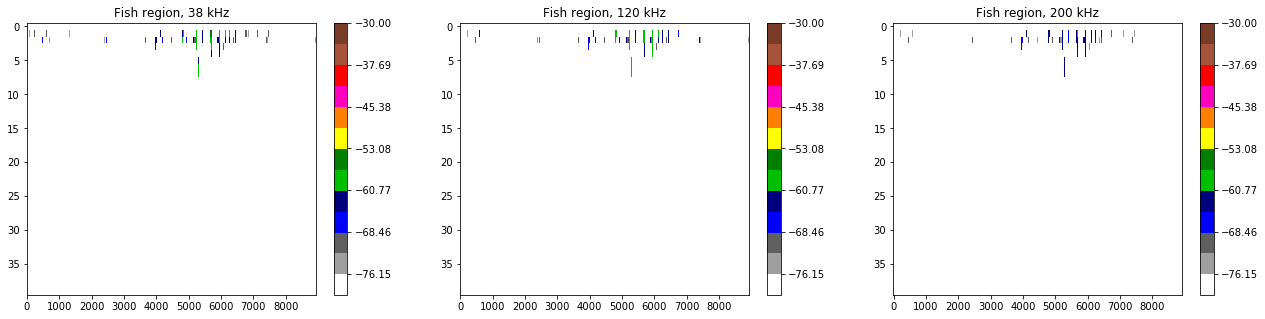

In [97]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_fish,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Fish region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_fish,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Fish region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_fish,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Fish region, 200 kHz')

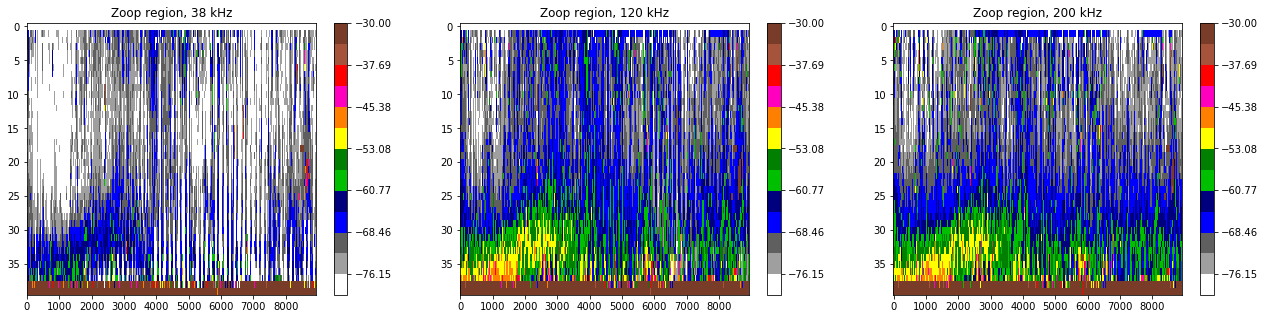

In [98]:
fig,(ax0,ax1,ax2) = plt.subplots(ncols=3,figsize=(22,5))
im0 = ax0.imshow(np.ma.masked_where(~idx_zoop,MVBS[0,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Zoop region, 38 kHz')
im1 = ax1.imshow(np.ma.masked_where(~idx_zoop,MVBS[1,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Zoop region, 120 kHz')
im2 = ax2.imshow(np.ma.masked_where(~idx_zoop,MVBS[2,:,:]),aspect='auto',cmap=e_cmap,norm=e_norm)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Zoop region, 200 kHz')